In [2]:
from inference.utils.vision_process import fetch_video

import torch
import matplotlib.pyplot as plt
import numpy as np


In [3]:
video_info = {"type": "video", "video": '/home/hpc/g102ea/g102ea12/lazypatches/rough/monkey.gif', "fps": 1}
video = fetch_video(video_info)
print(video.shape)

torch.Size([4, 3, 280, 392])


In [ ]:
def generate_video_with_mask(video_path, mask):
    video_info = {"type": "video", "video": '/home/hpc/g102ea/g102ea12/lazypatches/rough/monkey.gif', "fps": 2}
    extracted_video = fetch_video(video_info).permute(0, 2, 3, 1)
    patch_size = 14
    frames_with_mask = torch.zeros_like(extracted_video)
    for Ti,frame in enumerate(extracted_video.shape[0]):
        for Hi,h in enumerate(range(0, extracted_video.shape[1], patch_size)):
            for Wi,w in enumerate(range(0, extracted_video.shape[2], patch_size)):
                patch = frame[h:h+patch_size, w:w+patch_size, :]
                if mask[Ti, Hi, Wi]:
                    frames_with_mask[Ti, h+pat]
                    
    
    

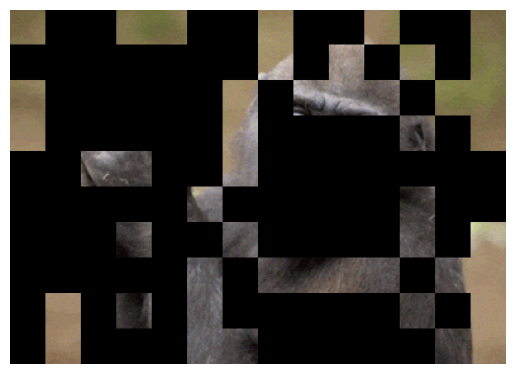

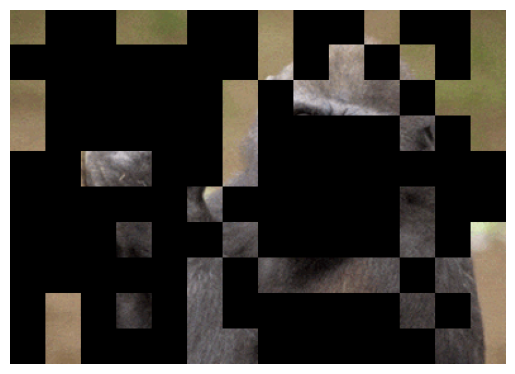

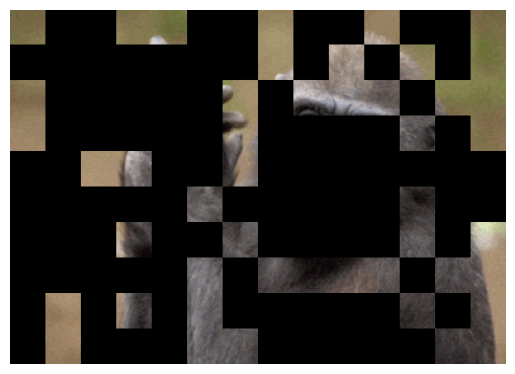

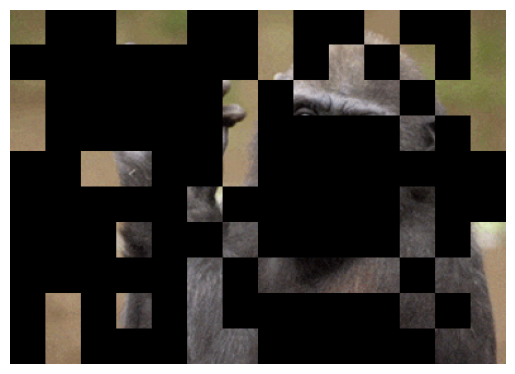

In [ ]:
img_tensor = video # 变换维度，从 [4, 3, 280, 392] 到 [4, 280, 392, 3]

# 创建一个 2x2 网格来显示图片
img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min())  # 归一化

# 将张量从 [4, 3, 280, 392] 转换为 [4, 280, 392, 3]
img_tensor = img_tensor.permute(0, 2, 3, 1)  # 变换维度，从 [4, 3, 280, 392] 到 [4, 280, 392, 3]

num_grids = (10, 14)
patch_size = (int(img_tensor.shape[1]//num_grids[0]), int(img_tensor.shape[2]//num_grids[1]))

n_frames = 2
mask = np.array([[1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,0.,0.,0.]])
def apply_random_mask_to_patches(img_tensor, patch_size):
    B, H, W, C = img_tensor.shape  # B: batch size, H: height, W: width, C: channels
    masked_image = torch.zeros_like(img_tensor)  # 用于存储 mask 后的图像

    # 对每张图片进行处理
    for i in range(B):
        img = img_tensor[i]  # 获取一张图片，形状 [H, W, C]
        
        # 对每个 patch 进行处理
        for h in range(0, H, patch_size[0]):
            for w in range(0, W, patch_size[1]):
                # 选取一个 patch
                patch = img[h:h+patch_size[0], w:w+patch_size[1], :]
                
                # 生成随机 mask (28x28)，值为0或1，控制整个 patch 遮挡
                # mask = torch.randint(0, 2, (1,), dtype=torch.float32)  # 生成一个随机二进制值 (0 或 1)
                # mask = ()
                
                # 如果 mask 为 1，则保留 patch 内容；如果 mask 为 0，则将 patch 屏蔽
                if mask[h//28][w//28] == 1:
                    masked_image[i, h:h+patch_size[0], w:w+patch_size[1], :] = patch
                # 如果 mask == 0, patch 会保持为 0（即被遮挡）
    
    return masked_image

# 调用函数并处理
masked_image = apply_random_mask_to_patches(img_tensor, patch_size)

# 显示每张图像的处理结果
for i in range(img_tensor.shape[0]):  # 显示四张处理过的图像
    plt.figure()
    plt.imshow(masked_image[i].numpy())
    plt.axis('off')  # 关闭坐标轴
    plt.show()

In [25]:
import cv2

In [32]:
print(masked_image.shape, type(masked_image), torch.min(masked_image), torch.max(masked_image))
# 将 masked_image 从 [4, 280, 392, 3] 转换为 [4, 3, 280, 392] 的 numpy 数组格式，以适应 OpenCV
masked_image_np = masked_image.permute(0, 3, 1, 2).numpy()  # [4, 3, 280, 392] -> [4, 3, 280, 392]
print(masked_image_np.shape)
# 为保存视频，设置视频编码
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 使用 XVID 编码器（适用性广泛）
fps = 1  # 每秒 10 帧，可以根据需要调整
width = masked_image_np.shape[3]  # 视频宽度 392
height = masked_image_np.shape[2]  # 视频高度 280
print(width, height)

# 创建一个 VideoWriter 对象来保存视频
out = cv2.VideoWriter('output_video.mp4', fourcc, fps, (width, height))

# 将每一帧添加到视频中
for i in range(masked_image.shape[0]):
    # 获取当前图像帧，并将其转换为 BGR 格式（OpenCV 使用 BGR，而不是 RGB）
    frame = masked_image_np[i].transpose(1, 2, 0) * 255  # 转换为 [height, width, channels] 并放大到 [0, 255]
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    frame = np.uint8(frame)  # 确保数据类型为 uint8
    print(np.min(frame), np.max(frame))
    # 将帧写入视频
    out.write(frame)

# 释放 VideoWriter 对象
out.release()

torch.Size([4, 280, 392, 3]) <class 'torch.Tensor'> tensor(0.) tensor(1.)
(4, 3, 280, 392)
392 280
0 240
0 240
0 255
0 255


In [37]:
import imageio

input_video = 'output_video.mp4'  # 视频文件路径
output_gif = 'output_video.gif'  # GIF 输出文件路径


# 使用 imageio 读取视频
video = imageio.get_reader(input_video)

# 使用 imageio 将视频保存为 GIF
with imageio.get_writer(output_gif, mode='I', duration=4) as writer:  # duration 设置每帧之间的间隔（例如 1/30 秒）
    for frame in video:
        writer.append_data(frame)  # 将每一帧写入 GIF

print(f'GIF saved to {output_gif}')

GIF saved to output_video.gif
